# Notebook to demonstrate Zero shot and Few shot Learning

In [1]:
import json
import pandas as pd 
from langchain_groq.chat_models import ChatGroq
import numpy as np

In [2]:
with open('secrets.json') as f:
    secrets = json.load(f)

In [3]:
# Groq API and Models 
Groq_Token = secrets["API_KEY"]  # Do not share this key with anyone

groq_models = {"llama3-70b": "llama3-70b-8192", "mixtral": "mixtral-8x7b-32768", "gemma-7b": "gemma-7b-it","llama3.1-70b":"llama-3.1-70b-versatile","llama3-8b":"llama3-8b-8192","llama3.1-8b":"llama-3.1-8b-instant","gemma-9b":"gemma2-9b-it"}

In [4]:
import os
train_data = os.path.join('./Combined/Train')
test_data = os.path.join('./Combined/Test')
activities = ['LAYING', 'SITTING', 'STANDING','WALKING','WALKING_DOWNSTAIRS','WALKING_UPSTAIRS']
x_train=[]
y_train=[]
x_test=[]
y_test=[]
for activity in activities:
    folder = os.path.join(train_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(train_data,activity,csv),header=0)
        x_train.append(df.values[:500])
        y_train.append(activity)
        
for activity in activities:
    folder = os.path.join(test_data,activity)
    data = os.listdir(folder)
    # print(len(data))
    for csv in data:
        df=pd.read_csv(os.path.join(test_data,activity,csv),header=0)
        x_test.append(df.values[:500])
        y_test.append(activity)
x_test=np.array(x_test)
y_test=np.array(y_test)
x_train=np.array(x_train)
y_train=np.array(y_train)

In [5]:
total_acceleration_test = x_test[:,:,0]**2 + x_test[:,:,1]**2 + x_test[:,:,2]**2
total_acceleration_train = x_train[:,:,0]**2 + x_train[:,:,1]**2 + x_train[:,:,2]**2

In [6]:
import tsfel
from tsfel.feature_extraction.features import calc_mean, calc_var, pk_pk_distance,mean_abs_deviation,autocorr,auc

In [7]:
def extract_features(data):
    tsfel_features=[]
    for i in range(len(data)):
        mean = calc_mean(data[i])
        var = calc_var(data[i])
        dist = pk_pk_distance(data[i])
        mad = mean_abs_deviation(data[i])
        corr = autocorr(data[i])
        auc_ = auc(data[i],50)
        tsfel_features.append([mean,var,dist,mad,corr,auc_])
    return tsfel_features

In [8]:
tsfel_features_train=np.array(extract_features(total_acceleration_train))
tsfel_features_test=np.array(extract_features(total_acceleration_test))

In [11]:
print(tsfel_features_train.shape)
print(tsfel_features_test.shape)

(126, 6)
(54, 6)


**NOTE : DO NOT SHARE THE API KEY WITH ANYONE. DO NOT COMMIT THE API KEY TO GITHUB.**

Always do a sanity check before committing the code to github. If the key is found in the code, you will be penalized with a 0.5 marks deduction.

# Zero Shot 

In [6]:
# Statement 
sentence = "The product quality is amazing but the delivery was delayed. However I am happy with the customer service."

# System Prompts 
query = f"""
* You are a sentiment analysis model. 
* Your task is to analyze the sentiment expressed in the given text and classify it as 'positive', 'negative', or 'neutral'. 
* Provide the sentiment label and, if necessary, a brief explanation of your reasoning.

Sentence: {sentence}
""" 

# To use Groq LLMs 
model_name = "llama3-70b" # We can choose any model from the groq_models dictionary
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

print(answer.content)

Sentiment label: Neutral

Explanation: The sentence expresses mixed sentiments. The words "amazing" and "happy" convey a positive sentiment, indicating satisfaction with the product quality and customer service. However, the phrase "delivery was delayed" expresses a negative sentiment, indicating dissatisfaction with the delivery experience. Overall, the positive and negative sentiments balance each other out, resulting in a neutral sentiment label.


# Few Shot

In [7]:
# Statement 
sentence = "The product quality is amazing but the delivery was delayed. However I am happy with the customer service."

# System Prompts 
query = f"""
* You are a sentiment analysis model. 
* Your task is to analyze the sentiment expressed in the given text and classify it as 'positive', 'negative', or 'neutral'. 
* Provide the sentiment label and, if necessary, a brief explanation of your reasoning.

Here are few examples:
1. Sentence: 'The customer service was excellent, and I received my order quickly.'
Sentiment: Positive

2. Sentence: 'The food was bland and the service was slow.'
Sentiment: Negative

3. Sentence: 'The product is okay, but it's not worth the price.'
Sentiment: Neutral

Sentence: {sentence}
""" 

# To use Groq LLMs 
model_name = "llama3-70b" # We can choose any model from the groq_models dictionary
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
answer = llm.invoke(query)

print(answer.content)

Sentiment: Positive

Explanation: Although the sentence mentions a negative aspect ("the delivery was delayed"), the positive sentiments ("The product quality is amazing" and "I am happy with the customer service") outweigh the negative one, resulting in an overall positive sentiment. The use of the word "amazing" and "happy" also indicates a strong positive emotion, which contributes to the positive sentiment classification.


In [12]:
print("Shape of Test Data: ",len(x_test))

Shape of Test Data:  54


In [14]:
true=0
for i in range(len(tsfel_features_test)):
    data = tsfel_features_test[i]
    query = f"""

    * Don't give multiple lines output. Just output a single word.
    * You are a human activity recognition model.
    * Your task is to predict the activity based on the time series data of accelerometer of 10 seconds sampled at 50 Hz sampling rate.
    * Give your response as just the activity label name from "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", "WALKING_UPSTAIRS".
    
    data = {data}
    """

    model_name = "llama3-70b" 
    llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)
    answer = llm.invoke(query)
    print(answer.content,i+1)
    if answer.content == y_test[i]:
        true+=1

STANDING 1
STANDING 2
STANDING 3
STANDING 4
STANDING 5
STANDING 6
STANDING 7
STANDING 8
STANDING 9
STANDING 10
STANDING 11
STANDING 12
STANDING 13
STANDING 14
STANDING 15
STANDING 16
STANDING 17
STANDING 18
STANDING 19
STANDING 20
STANDING 21
STANDING 22
STANDING 23
STANDING 24
STANDING 25
STANDING 26
STANDING 27
STANDING 28
STANDING 29
STANDING 30
STANDING 31
STANDING 32
STANDING 33
STANDING 34
STANDING 35
STANDING 36
STANDING 37
STANDING 38
STANDING 39
STANDING 40
STANDING 41
STANDING 42
STANDING 43
STANDING 44
STANDING 45
STANDING 46
STANDING 47
STANDING 48
STANDING 49
STANDING 50
STANDING 51
STANDING 52
STANDING 53
STANDING 54


In [16]:
accuracy = true/len(x_test)
print(f"Accuracy of Zero-Shot = {accuracy*100} %")

Accuracy of Zero-Shot = 16.666666666666664%


In [17]:
print(x_train.shape)
print(x_test.shape)

(126, 500, 3)
(54, 500, 3)


In [9]:
model_name = "llama3-70b"
llm = ChatGroq(model=groq_models[model_name], api_key=Groq_Token, temperature=0)

In [19]:
print(y_train)

['LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING'
 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING'
 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'LAYING' 'SITTING' 'SITTING'
 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING'
 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING'
 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'SITTING' 'STANDING' 'STANDING'
 'STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING'
 'STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING'
 'STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING' 'STANDING'
 'STANDING' 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING' 'WALKING'
 'WALKING' 'WALKING_DOWNSTAIRS' 'WALKING_DOWNSTAIRS' 'WALKING_DOWNSTAIRS'
 'WALKING_DOWNSTAIRS' 'WALKING_DOWNSTAIRS' 'WALKING_DOWNSTAIRS'
 'WALKING_DOWNSTAIRS

In [29]:
responses=[]

In [11]:
responses = []  # Initialize the list to store responses

# Assuming there are 9 examples for each of the 6 activities
activity_count = 6
examples_per_activity = 1  # Number of examples to take per activity

# Constructing the few-shot examples by taking one example from each activity
few_shot_examples = ""
for j in range(activity_count):
    index1 = j * 9 
    index2 = j*9+2
    index3 = j*9 + 4
    few_shot_examples += f"""
    Train Example 1:
    Features: {tsfel_features_train[index1]}
    Label: {y_train[index1]}

    Train Example 2:
    Features: {tsfel_features_train[index2]}
    Label: {y_train[index2]}

    Train Example :
    Features: {tsfel_features_train[index3]}
    Label: {y_train[index3]}
    """

# Loop over the test data
for i in range(len(tsfel_features_test)):
    query = f"""
        * Your response should be a single word representing the activity label (e.g., 'WALKING').
        * You are a human activity recognition model.
        * Your task is to predict the activity label based on the given featurized time series data.
        * Each data point has 6 features: mean, variance, peak-to-peak distance, mean absolute deviation, correlation, and area under the curve.
        * The activities can be one of "LAYING", "SITTING", "STANDING", "WALKING", "WALKING_DOWNSTAIRS", or "WALKING_UPSTAIRS".
        
        
        Here are some training examples:
        {few_shot_examples}
        
        Now, given the test data below, predict the activity label:
        
        Test Data (Features): {tsfel_features_test[i]}
    """

    # Invoke the language model with the query
    answer = llm.invoke(query)
    ans = answer.content.strip()  # Strip any extra whitespace
    responses.append(ans)
    print(i, ans, len(responses))


0 LAYING 1
1 LAYING 2
2 LAYING 3
3 LAYING 4
4 SITTING 5
5 SITTING 6
6 LAYING 7
7 LAYING 8
8 LAYING 9
9 LAYING 10
10 SITTING 11
11 LAYING 12
12 LAYING 13
13 STANDING 14
14 SITTING 15
15 LAYING 16
16 LAYING 17
17 SITTING 18
18 STANDING 19
19 STANDING 20
20 STANDING 21
21 STANDING 22
22 STANDING 23
23 STANDING 24
24 STANDING 25
25 STANDING 26
26 SITTING 27
27 WALKING 28
28 WALKING 29
29 WALKING 30
30 WALKING 31
31 WALKING 32
32 WALKING 33
33 WALKING 34
34 WALKING 35
35 WALKING 36
36 WALKING 37
37 WALKING 38
38 WALKING 39
39 WALKING 40
40 WALKING 41
41 WALKING 42
42 WALKING 43
43 WALKING 44
44 WALKING 45
45 WALKING 46
46 WALKING 47
47 WALKING 48
48 WALKING 49
49 WALKING 50
50 WALKING 51
51 WALKING 52
52 WALKING 53
53 WALKING 54


In [12]:
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
import seaborn as sns
import matplotlib.pyplot as plt


Accuracy = 0.5
Precision = 0.38425925925925924
Recall = 0.5
F1 Score = 0.40925925925925927


e:\ES 335 -  Machine Learning\es335-24-fall-assignment-1-master\env\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


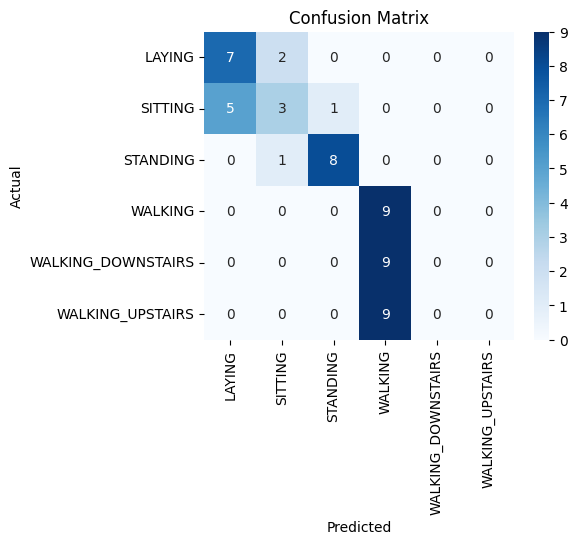

In [13]:
print(f"Accuracy = {accuracy_score(y_test,responses)}")
print(f"Precision = {precision_score(y_test,responses,average='weighted')}")
print(f"Recall = {recall_score(y_test,responses,average='weighted')}")
print(f"F1 Score = {f1_score(y_test,responses,average='weighted')}")
cm = confusion_matrix(y_test,responses)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, xticklabels=activities, yticklabels=activities, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()